References:
- https://github.com/elisno/outlier_mnli/blob/main/outlier_mnli.ipynb
- https://towardsdatascience.com/understanding-outliers-in-text-data-with-transformers-cleanlab-and-topic-modeling-db3585415a19

In [1]:
import pickle
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from umap import UMAP
from cleanlab.outlier import OutOfDistribution

# def getSectionContent(section):
#     return section['page']['title'].replace('\n', ' ').strip() + ' ' + section['page']['summary'].replace('\n', ' ').strip() + ' ' + section['content'].replace('\n', ' ').strip()

def getSectionContent(section):
    return section['content'].replace('\n', ' ').strip()

embeddings_location = 'rest_embeddings.pkl'
outlier_scores_location = 'rest-concatenated_scores.pkl'

with open(embeddings_location, "rb") as reader:
    cache_data = pickle.load(reader)
    sections = cache_data['sections']
    corpus_embeddings = cache_data['embeddings']

passages = []
passages.extend(map(getSectionContent, sections))
print('Passages:', len(passages))

/home/julrich/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-26 22:34:23.329177: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Passages: 87635


In [2]:
ood = OutOfDistribution()
train_outlier_scores = ood.fit_score(features=corpus_embeddings)

Fitting OOD estimator based on provided features ...


In [3]:
with open(outlier_scores_location, "wb") as writer:
    pickle.dump({'scores': train_outlier_scores}, writer)

In [25]:
with open(outlier_scores_location, "rb") as reader:
    cache_data = pickle.load(reader)
    train_outlier_scores = cache_data['scores']

In [4]:
numpy_passages = np.array(passages)
numpy_sections = np.array(sections)
numpy_embeddings = np.array(corpus_embeddings)

top_train_outlier_idxs = (train_outlier_scores).argsort()[:30]
outlier_passages = numpy_passages[top_train_outlier_idxs]
outlier_sections = numpy_sections[top_train_outlier_idxs]

df = pd.DataFrame.from_records(pd.json_normalize(outlier_sections, sep='_'))
df['score'] = train_outlier_scores[top_train_outlier_idxs]
df.head(15)

,content,tokens,page_url,page_title,page_summary,score
0,\nWhat is the air-speed velocity of an unladen...,186,https://clarity.design/documentation/wizards,Clarity Design System - Documentation - Wizards,Wizards provide a way to go through a sequence...,0.522855
1,I’m trying to figure out how to get ground pec...,84,https://www.designbetter.co/conversations/jere...,Jeremy Faludi: exploring sustainable design be...,"Featuring Jeremy Faludi Assistant Professor, D...",0.525810
2,\nI tried to make my own sneakers. That was sh...,89,https://danmall.com/posts/2021-year-in-review/,"“2021 Year in Review,” an article by Dan Mall","Continuing the tradition from 2020, 2019, and ...",0.532256
3,Middle divider\nToothbrush$4.50Pinstriped corn...,68,https://mui.com/material-ui/react-divider/,React Divider component - Material UI,Divider A divider is a thin line that groups c...,0.532576
4,\n\n\n\n\n\n\nBeats Solo3 Wireless\nBeats Solo...,296,https://danmall.com/posts/should-you-use-boots...,“Should You Use Bootstrap or Material Design f...,Bootstrap and Material Design are incredibly t...,0.536293
5,What is it?\nPeople with vestibular disorders ...,201,https://www.a11yproject.com/posts/understandin...,Background: A primer to vestibular disorders -...,A primer to vestibular disorders Table of Cont...,0.538265
6,\nI played Wordle for 272 days straight. I mea...,44,https://danmall.com/posts/2022-year-in-review/,"“2022 Year in Review,” an article by Dan Mall","Continuing the tradition from 2021, 2020, 2019...",0.539974
7,\nAphrodite\nFela\nStitches\n,98,https://nextjs.org/docs/basic-features/built-i...,Basic Features: Built-in CSS Support | Next.js,Next.js allows you to import CSS files from a ...,0.540468
8,They even had the audacity to send follow-up s...,208,https://bradfrost.com/blog/post/bradfrost-dot-...,bradfrost.com | Brad Frost,"bradfrost.com After 10 years, I finally secure...",0.541797
9,\n\nJames Baldwin\nAnyone who has ever struggl...,206,https://paste.twilio.design/components/table,Table - Paste: The Design System for building ...,"|Agents||Skills||Tasks| |Adam Brown||English, ...",0.542551


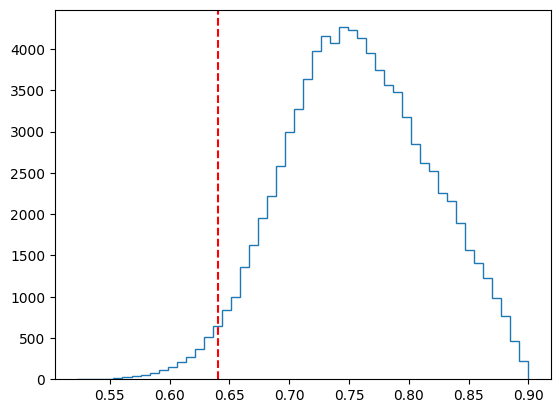

In [5]:
threshold = np.percentile(train_outlier_scores, 2.5)

plt_range = [train_outlier_scores.min(), train_outlier_scores.max()]

counts, bins = np.histogram(train_outlier_scores, range=plt_range, bins=50)
diagram = plt.stairs(counts, bins)
plt.axvline(threshold, color='r', linestyle='--')

In [8]:
sorted_ids = train_outlier_scores.argsort()
outlier_scores = train_outlier_scores[sorted_ids]
outlier_ids = sorted_ids[outlier_scores > threshold]
rest_outlier_ids = sorted_ids[outlier_scores <= threshold]

selected_outlier_sections = numpy_sections[outlier_ids]
selected_outlier_embeddings = numpy_embeddings[outlier_ids]
selected_outlier_scores = outlier_scores[outlier_ids]

rest_sections = numpy_sections[rest_outlier_ids]
rest_embeddings = numpy_embeddings[rest_outlier_ids]
rest_scores = outlier_scores[rest_outlier_ids]

df = pd.DataFrame.from_records(pd.json_normalize(selected_outlier_sections, sep='_'))
df['score'] = train_outlier_scores[outlier_ids]
df.head(15)

,content,tokens,page_url,page_title,page_summary,score
0,Demo\nSimple\nThe default pattern for displayi...,279,https://design.gitlab.com/data-visualization/s...,Single stat | Pajamas Design System,Single stat The single stat component displays...,0.640555
1,Commas\nUse serial commas (also called Oxford ...,131,https://acorn.firefox.com/latest/content-guide...,Punctuation- Firefox Design Systems,Punctuation Ampersand (&) Avoid using unless ...,0.640596
2,To know more about the supported events and th...,43,https://mui.com/x/migration/migration-data-gri...,Migration from v5 to v6 - MUI X,Migration from v5 to v6 This guide describes t...,0.640605
3,Reagent: Minimalistic React for ClojureScript\...,158,https://react.dev/blog/2014/02/05/community-ro...,Community Round-up #15 – React Blog,Community Round-up #15 Jonas Gebhardt This blo...,0.640607
4,"Lorem ipsum dolor sit amet, consectetur adipis...",223,https://build.washingtonpost.com/v0/dev/uncate...,Accordion | WPDS,"Accordion Lorem ipsum dolor sit amet, consecte...",0.640628
5,WPDS Media At-Rules,6,https://build.washingtonpost.com/foundations/b...,WPDS - Breakpoints | Foundations,Breakpoints in Style Objects While not recomme...,0.640630
6,\n\n\n Drag and Drop your\n file\n \n\n Select...,64,https://react-spectrum.adobe.com/react-spectru...,IllustratedMessage – React Spectrum,IllustratedMessage An IllustratedMessage displ...,0.640654
7,const AvatarDemo = () => (\n \n\n\n\n\n CT\n \...,293,https://www.radix-ui.com/docs/primitives/compo...,Avatar – Radix UI,PD import React from 'react';import * as Avata...,0.640662
8,"Almost a year into shipping books, I still gen...",164,https://bradfrost.com/blog/post/self-publishin...,Self-Publishing a Book for Fun and Profit | Br...,Self-Publishing a Book for Fun and Profit I wr...,0.640687
9,Select the greatest sci-fi franchise of all ti...,48,https://comet.discoveryeducation.com/component...,Comet Forms,"If the field has an associated error message, ...",0.640704


In [57]:
with open('outlier_embeddings', "wb") as writer:
    pickle.dump({'sections': selected_outlier_sections, 'embeddings': selected_outlier_embeddings}, writer)

with open('rest_embeddings', "wb") as writer:
    pickle.dump({'sections': rest_sections, 'embeddings': rest_embeddings}, writer)

In [9]:
df_outliers = pd.DataFrame.from_records(pd.json_normalize(np.random.choice(selected_outlier_sections, 10), sep='_'))
df_outliers.head(10)

,content,tokens,page_url,page_title,page_summary
0,"function App() { const [dimensions, ref] = use...",274,https://orbit.kiwi/changelog/,Changelog | Orbit,CountryFlag:The default code for CountryFlag i...
1,Popovers\nChanged\n\nBase popovers\nFooter bac...,228,https://www.lightningdesignsystem.com/release-...,Release Notes - Lightning Design System,Release Notes About the availability of these ...
2,If you don't need a full-fledged app framework...,197,https://svelte.dev/docs,Docs • Svelte,Documentation Before we begin permalink This p...
3,Zone - Multipurpose Landing Page + UI Kit - MU...,292,https://mui.com/store/items/zone-landing-page/,Zone - Multipurpose Landing Page + UI Kit - MU...,It includes many pages with different topics: ...
4,Tabs organize content by grouping similar info...,18,https://cultureamp.design/components/tabs/,Tabs - Kaizen Design System,Tabs Tabs organize content by grouping similar...
5,Key features for content\n\nBrainstorming tool...,143,https://backlight.dev/mastery/best-design-syst...,Best Design System tools | Design System Maste...,Best Design System tools # Here is our curated...
6,Foundational\nWe solve the common problems for...,164,https://atlassian.design/resources/atlassian-d...,Values and principles - Resources - Atlassian ...,We use the Atlassian Design System values and ...
7,You can contact a supervisory authority with a...,274,https://designstrategy.guide/privacy-policy/,Privacy policy - Design strategy guide,Privacy policy Responsible party pursuant to d...
8,"const { content, title, date } = Astro.props;\...",116,https://docs.astro.build/en/guides/cms/content...,Contentful & Astro 🚀 Astro Documentation,Contentful & Astro Contentful is a headless CM...
9,Body content should be actionable\nMake sure t...,193,https://cultureamp.design/components/guidance-...,Guidance Block - Kaizen Design System,Guidance Block A Guidance Block provides a fam...


In [10]:
df_rest = pd.DataFrame.from_records(pd.json_normalize(np.random.choice(rest_sections, 10), sep='_'))
df_rest.head(10)

,content,tokens,page_url,page_title,page_summary
0,Containers\nSM\nMD\nLG\nXL,16,https://rivet.iu.edu/components/preview/contai...,Containers,
1,Contributing\nUnless you explicitly state othe...,107,https://www.kickstartDS.com/docs/intro/cli,kickstartDS CLI | kickstartDS docs,kickstartDS CLI About The kickstartDS CLI help...
2,npm,8,https://nuxtjs.org/docs/get-started/upgrading,Nuxt - Upgrading,"Upgrading Upgrading Nuxt is quick, but more in..."
3,\nInstall Ubuntu\n\nNavigate to this link (on ...,192,https://help.knapsack.cloud/article/31-running...,Running Knapsack Locally - Knowledge Base | Kn...,Running Knapsack Locally In This Article: Prer...
4,\n@tde_badsender\nBadsender\nlepatron.email\n2...,81,https://backlight.dev/sessions/coding-design-s...,Backlight - Build Design Systems - Tool for fr...,Design Systems for Emails UI with Thomas Defo...
5,\n\n\n\n Dark Menu\n ...,201,https://comet.discoveryeducation.com/component...,Comet Dropdown Menus,Default Trigger a dropdown menu using a click ...
6,How to check\n\nGoogle Lighthouse UX audit\nCh...,79,https://designsystem.digital.gov/maturity-model/,USWDS maturity model | U.S. Web Design System ...,How to use USWDS USWDS maturity model Use the ...
7,\nSierra Club (Donate) – Protecting the enviro...,267,https://bradfrost.com/blog/post/deliberate-giv...,Deliberate Giving | Brad Frost,"Deliberate Giving Like a lot of people, I’ve i..."
8,\nA seven-line graph shows the changes in diff...,86,https://comet.discoveryeducation.com/component...,Comet Embedded Images,Default The default embedded image should incl...
9,What types of payment do you accept?Knapsack i...,120,https://www.knapsack.cloud/old-pages/pricing-old,Knapsack's Starter and Enterprise Plans | Plan...,Knapsack pricing is based on the number of con...


In [24]:
sorted_ids = train_outlier_scores.argsort()
outlier_scores = train_outlier_scores[sorted_ids]
outlier_ids = sorted_ids[outlier_scores < threshold]

selected_outlier_sections = numpy_sections[outlier_ids]

df = pd.DataFrame.from_records(pd.json_normalize(selected_outlier_sections, sep='_'))
df.tail(15)

,content,tokens,page_url,page_title,page_summary
4505,\nRight arrow key on a cell will move the user...,131,https://www.lightningdesignsystem.com/componen...,Tree Grid - Lightning Design System,|Choose a row| Account Name Sort by: Employees...
4506,"Human, but not individual\nToo much personalit...",247,https://polaris.shopify.com/content/merchant-t...,Merchant-to-customer content — Shopify Polaris,Merchant-to-customer content Shopify creates c...
4507,\nGeneral App\nGeneral E-commerce\nGeneral Ana...,276,https://mui.com/store/items/minimal-dashboard/,Minimal - Client &amp; Admin Dashboard - MUI S...,| | 📦 Package | |Standard | |Plus | |Extended ...
4508,"For example, you will use Style Dictionary, wh...",48,https://designstrategy.guide/design-management...,Design Tokens 101 - Design strategy guide,Naming Conventions Handoff process The powerfu...
4509,"For example, you will use Style Dictionary, wh...",48,https://designstrategy.guide/design-system/des...,Design Tokens 101 - Design strategy guide,Naming Conventions Handoff process The powerfu...
4510,itions/)noneleftleftleftnonepositionpositionpo...,96,https://mui.com/system/properties/,Properties - MUI System,Properties This page lists all of the custom s...
4511,Yosemite\nNational Park\nFeatured11710.4k### R...,174,https://mui.com/joy-ui/react-card/,React Card component - Joy UI,Skip to content Card A card is a generic conta...
4512,\nStepper: remove size prop (49f31ce)\n,50,https://orbit.kiwi/changelog/,Changelog | Orbit,CountryFlag:The default code for CountryFlag i...
4513,"""Developer (43671)"")Documentation (47.49KB)Eco...",234,https://atlassian.design/resources/logo-library,Logo library - Resources - Atlassian Design Sy...,Before using these logos it's good practice to...
4514,Scott Hutcheson\nProduct Engineer at CodeSandb...,68,https://www.radix-ui.com/case-studies/codesandbox,CodeSandbox – Case studies – Radix UI,Case study CodeSandbox Radix has significantly...


In [11]:
selected_outlier_subset_embeddings = numpy_embeddings[outlier_ids]

umap_fit = UMAP(n_components=3, n_neighbors=8, random_state=42)
selected_outlier_subset_embeddings_umap = umap_fit.fit_transform(selected_outlier_subset_embeddings)

/home/julrich/.local/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [ ]:
from urllib.parse import urlparse

df = pd.DataFrame.from_records(pd.json_normalize(selected_outlier_sections, sep='_'))
df['score'] = train_outlier_scores[outlier_ids]
df['content'].apply(lambda x: x.replace('\n', ' ').strip())
df['x'] = selected_outlier_subset_embeddings_umap[:, 0]
df['y'] = selected_outlier_subset_embeddings_umap[:, 1]
df['z'] = selected_outlier_subset_embeddings_umap[:, 2]
df['domain'] = df['page_url'].apply(lambda x: urlparse(x).netloc)

fig_3d = px.scatter_3d(
    df, x='x', y='y', z='z',
    color=df.domain, labels={'color': 'domain'}, hover_data=['content'],
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

df.sample(10)

In [28]:
umap_fit = UMAP(n_components=3, n_neighbors=8, random_state=42)
rest_embeddings_umap = umap_fit.fit_transform(rest_embeddings)

In [ ]:
from urllib.parse import urlparse

df = pd.DataFrame.from_records(pd.json_normalize(rest_sections, sep='_'))
df['score'] = train_outlier_scores[rest_outlier_ids]
df['content'].apply(lambda x: x.replace('\n', ' ').strip())
df['x'] = rest_embeddings_umap[:, 0]
df['y'] = rest_embeddings_umap[:, 1]
df['z'] = rest_embeddings_umap[:, 2]
df['domain'] = df['page_url'].apply(lambda x: urlparse(x).netloc)

fig_3d = px.scatter_3d(
    df, x='x', y='y', z='z',
    color=df.domain, labels={'color': 'domain'}, hover_data=['content'],
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()

df.sample(10)